## Music Generation with LSTM
### DTSA 5511 - Final Project
GitHub: 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import IPython
from IPython.display import Audio, Image
import midi2audio
from midi2audio import FluidSynth

import music21
from music21 import midi, chord, corpus, converter, duration, instrument, note, stream

import keras
from keras.models import Model
from keras.layers import Dense, LSTM, Bidirectional, Input, Concatenate, Dropout, Activation, Embedding, Reshape
from keras.layers import Flatten, Permute, RepeatVector, TimeDistributed
from keras.layers import Lambda, Multiply,Softmax
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import RMSprop

#### Required Libraries:

In [2]:
print('music21 version:', music21.__version__)

music21 version: 8.3.0


In [3]:
!pip show midi2audio

Name: midi2audio
Version: 0.1.1
Summary: Easy to use MIDI to audio or playback via FluidSynth
Home-page: https://github.com/bzamecnik/midi2audio
Author: Bohumir Zamecnik
Author-email: bohumir.zamecnik@gmail.com
License: MIT
Location: c:\users\welly\anaconda3\envs\tf_gpu\lib\site-packages
Requires: 
Required-by: 


In [4]:
!fluidsynth --version    # installed through Chocolatey

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

FluidSynth executable version 2.3.5
Sample type=float


In [2]:
music21.environment.set('musescoreDirectPNGPath', r"C:\Program Files\MuseScore 4\bin\MuseScore4.exe")

## 1. Problem Description and Dataset

For this final project, I decided to work on something 'fun'. A Neural Network that generates music: this idea appealed to me. I will be utilizing Bi-directional LSTM (Long Short-Term Memory). LSTM performs well for processing sequences of data with long-range dependencies, making it suitable for generating music. They can capture information from earlier time steps and remember it for an extended period. As for the dataset, I will use classical music MIDI files sourced from [*Classical Piano Midi Page*](http://www.piano-midi.de/midi_files.htm). The MIDI files contain compositions for a single instrument: piano, from various composers. I will focus specifically on works by Bach, Beethoven, Chopin, Mozart, and Debussy, who is considered a more modern composer compared to the others.

The goal is to generate music similar to the style of their original composers.

Code is based on my interpretation of the works by Alex Issa. Initially, I examined his works to understand the process, especially since this is my first time working with music notes. Subsequently, I wrote my own interpretation of the code.

#### Original Bach Composition

In [4]:
midi_file_path = os.path.join(os.getcwd(), 'bach', 'bach_846.mid')

In [5]:
original_score = converter.parse(midi_file_path).chordify()

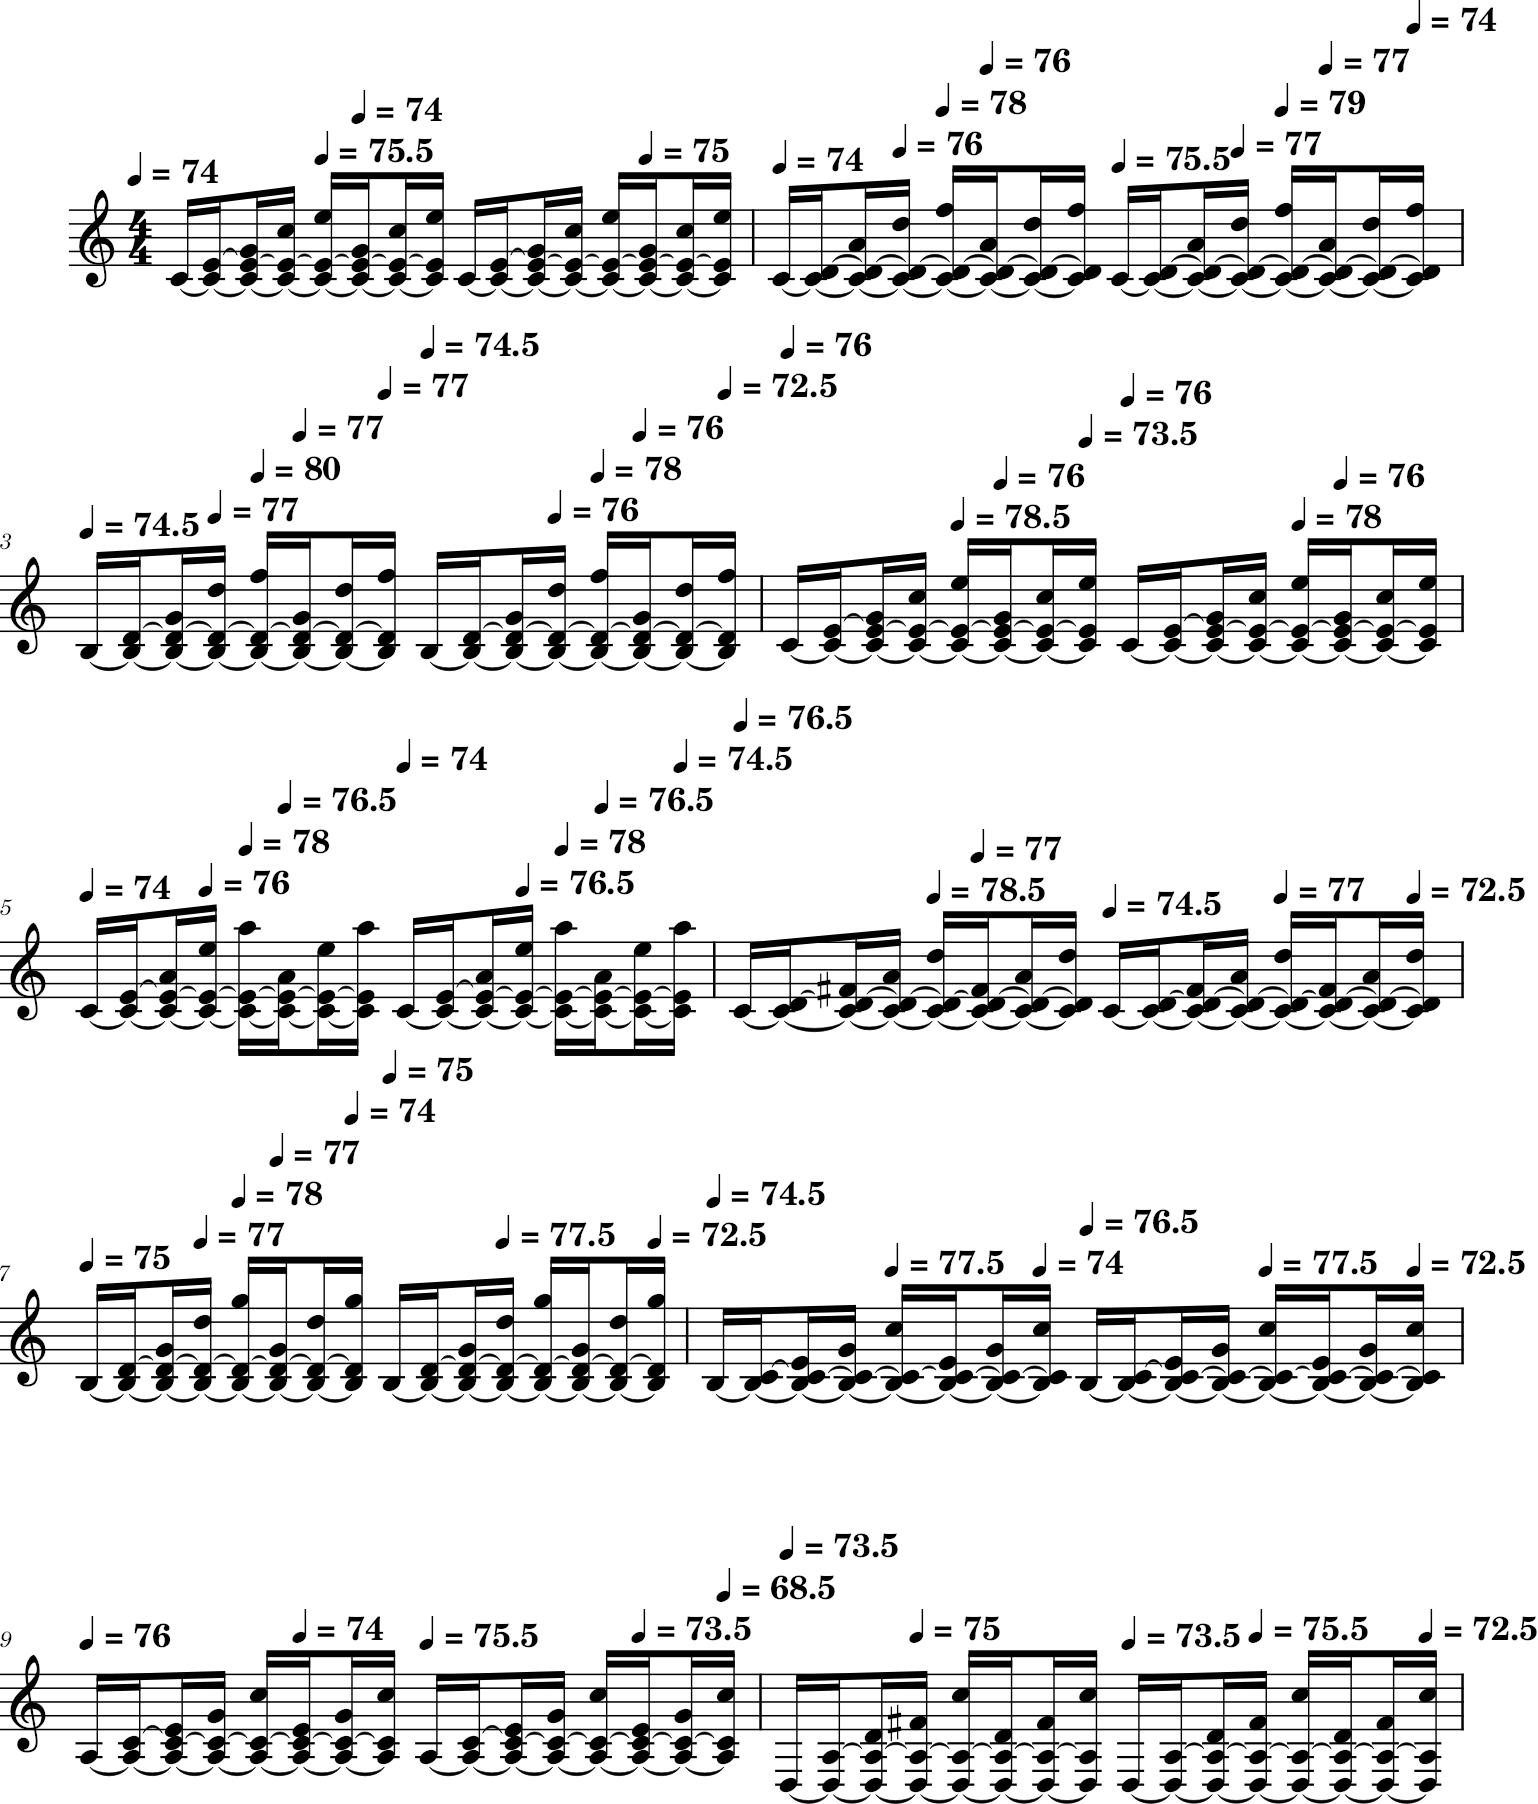

In [8]:
original_score.show()

In the context of music notation and MIDI files, individual sounds are often referred to as 'notes'. A note typically consists of two main components: pitch and duration. Pitch refers to the perceived frequency of a sound, determining its musical note value (e.g., A, B, C#). Duration refers to how long a note is held or played. We will loop through the score and extract the pitch and duration of each note into two lists. 

In [7]:
pitch = []
durations = []

for element in original_score.flat:    
    if isinstance(element, chord.Chord):
        pitch.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)

    if isinstance(element, note.Note):
        if element.isRest:
            pitch.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            pitch.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)   

In [8]:
pd.DataFrame({'Pitch': pitch, 'Durations': durations}).head(5)

,Pitch,Durations
0,C4,0.25
1,C4.E4,0.25
2,C4.E4.G4,0.25
3,C4.E4.C5,0.25
4,C4.E4.E5,0.25


In [3]:
def get_midi_list(midi_folder):
    file_list = glob.glob(os.path.join(midi_folder, "*.mid"))
    return file_list

In [4]:
midi_folder = ['bach', 'beethoven', 'chopin', 'debussy', 'mozart']

# let's first work with bach, then beethoven, chopin, debussy and mozart
music_list = get_midi_list(midi_folder[3])

In [5]:
notes = []
durations = []
intervals = range(1)
seq_len = 32

for i, file in enumerate(music_list):
    print(i+1, "Parsing %s" % file)
    original_score = converter.parse(file).chordify()        
    for interval in intervals:
        score = original_score.transpose(interval)
        notes.extend(['START'] * seq_len)
        durations.extend([0]* seq_len)

        for element in score.flat:                
            if isinstance(element, note.Note):
                if element.isRest:
                    notes.append(str(element.name))
                    durations.append(element.duration.quarterLength)
                else:
                    notes.append(str(element.nameWithOctave))
                    durations.append(element.duration.quarterLength)
                        
            if isinstance(element, chord.Chord):
                notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                durations.append(element.duration.quarterLength)

1 Parsing mozart\mz_311_1.mid
2 Parsing mozart\mz_311_3.mid
3 Parsing mozart\mz_330_1.mid
4 Parsing mozart\mz_330_3.mid
5 Parsing mozart\mz_331_1.mid
6 Parsing mozart\mz_331_2.mid
7 Parsing mozart\mz_331_3.mid
8 Parsing mozart\mz_332_3.mid
9 Parsing mozart\mz_545_1.mid


In [6]:
print('Number of notes and their corresponding durations:', len(notes))   # mozart

Number of notes and their corresponding durations: 22919


In [15]:
print('Number of notes and their corresponding durations:', len(notes))   # chopin

Number of notes and their corresponding durations: 8107


In [55]:
print('Number of notes and their corresponding durations:', len(notes))   # beethoven

Number of notes and their corresponding durations: 12971


### Get distinct sets of notes and durations

In [7]:
def get_distinct(elements):
    # get distinct name and its count
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

In [8]:
# get the distinct sets of notes and durations
note_names, num_notes = get_distinct(notes)
duration_names, num_durations = get_distinct(durations)
distincts = [note_names, num_notes, duration_names, num_durations]

In [9]:
note_names[:5]

['A1', 'A1.A2.A3', 'A1.A2.C4.E4.F#4', 'A1.A4.A5', 'A1.C#2.E2.A2']

In [10]:
duration_names[:5]

[0, Fraction(1, 12), Fraction(1, 6), 0.25, Fraction(1, 3)]

In [11]:
print('Number of distinct notes:', num_notes)
print('Number of distinct durations:', num_durations)

Number of distinct notes: 2515
Number of distinct durations: 20


In [9]:
def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))
    return (element_to_int, int_to_element)  

In [10]:
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

In [19]:
dict(list(duration_to_int.items())[:8])

{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7}

In [18]:
dict(list(note_to_int.items())[:8])

{'A1': 0,
 'A1.A2.A3': 1,
 'A1.A2.C4.E4.F#4': 2,
 'A1.A4.A5': 3,
 'A1.C#2.E2.A2': 4,
 'A1.C#2.E2.A2.C#5': 5,
 'A1.C#2.E2.A4': 6,
 'A1.C#4.E4': 7}

In [11]:
def prepare_sequences(notes, durations, lookups, distincts, seq_len=32):
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
    note_names, n_notes, duration_names, n_durations = distincts

    notes_network_input = []
    notes_network_output = []
    durations_network_input = []
    durations_network_output = []

    # create input sequences and the corresponding outputs
    for i in range(len(notes) - seq_len):
        notes_sequence_in = notes[i:i + seq_len]
        notes_sequence_out = notes[i + seq_len]
        notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
        notes_network_output.append(note_to_int[notes_sequence_out])

        durations_sequence_in = durations[i:i + seq_len]
        durations_sequence_out = durations[i + seq_len]
        durations_network_input.append([duration_to_int[char] for char in durations_sequence_in])
        durations_network_output.append(duration_to_int[durations_sequence_out])

    n_patterns = len(notes_network_input)

    # reshape the input into a format compatible with LSTM layers
    notes_network_input = np.reshape(notes_network_input, (n_patterns, seq_len))
    durations_network_input = np.reshape(durations_network_input, (n_patterns, seq_len))
    network_input = [notes_network_input, durations_network_input]

    notes_network_output = np_utils.to_categorical(notes_network_output, num_classes=n_notes)
    durations_network_output = np_utils.to_categorical(durations_network_output, num_classes=n_durations)
    network_output = [notes_network_output, durations_network_output]
    return (network_input, network_output)

In [12]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts)

In [22]:
network_input

[array([[2514, 2514, 2514, ..., 2514, 2514, 2514],
        [2514, 2514, 2514, ..., 2514, 2514, 1083],
        [2514, 2514, 2514, ..., 2514, 1083, 1342],
        ...,
        [ 577, 2082, 2411, ..., 2259, 2258, 2259],
        [2082, 2411, 2082, ..., 2258, 2259,  896],
        [2411, 2082,  550, ..., 2259,  896, 1024]]),
 array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0, 10],
        [ 0,  0,  0, ...,  0, 10,  3],
        ...,
        [ 3,  3,  3, ...,  3,  3,  3],
        [ 3,  3,  3, ...,  3,  3,  3],
        [ 3,  3,  3, ...,  3,  3,  3]])]

In [27]:
print('network input shape:', network_input[0].shape, network_input[1].shape)

network input shape: (22887, 32) (22887, 32)


In [29]:
print('network output shape:', network_output[0].shape, network_output[1].shape)

network output shape: (22887, 2515) (22887, 20)


In [13]:
def get_model(num_notes, num_durations, num_units=512, embed_size=100):
    K.clear_session()
    notes_in = Input(shape=(None,))
    durations_in = Input(shape=(None,))
    x1 = Embedding(num_notes, embed_size)(notes_in)
    x2 = Embedding(num_durations, embed_size)(durations_in)
    x = Concatenate()([x1, x2])
    x = Bidirectional(LSTM(units=num_units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))(x)
    x = LSTM(units=num_units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
    energies = Dense(1, activation='tanh')(x)   # energies: attention scores
    energies = Reshape([-1])(energies)
    alpha = Activation('softmax')(energies)     # attention weights
    alpha_repeated = Permute([2, 1])(RepeatVector(num_units)(alpha))
    context_vector = Multiply()([x, alpha_repeated])
    context_vector = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(num_units,))(context_vector)

    notes_out = Dense(num_notes, activation='softmax', name='pitch')(context_vector)
    durations_out = Dense(num_durations, activation='softmax', name='duration')(context_vector)
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    att_model = Model([notes_in, durations_in], alpha)
    opt = RMSprop(learning_rate=0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model, att_model

In [14]:
model, att_model = get_model(num_notes, num_durations)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    251500      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    2000        ['input_2[0][0]']                
                                                                                              

In [33]:
# we use att_model in prediction
att_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    251500      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    2000        ['input_2[0][0]']                
                                                                                            

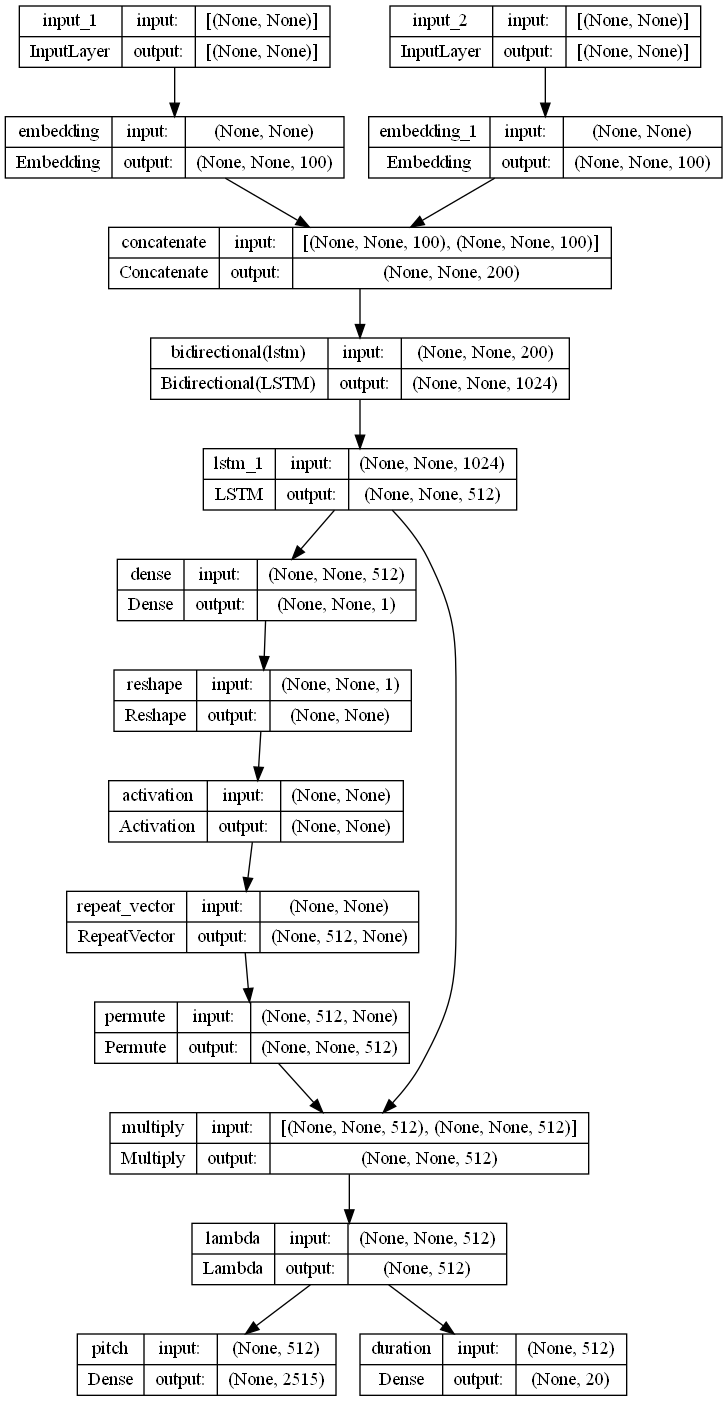

In [34]:
plot_model(model, show_shapes = True, show_layer_names = True)

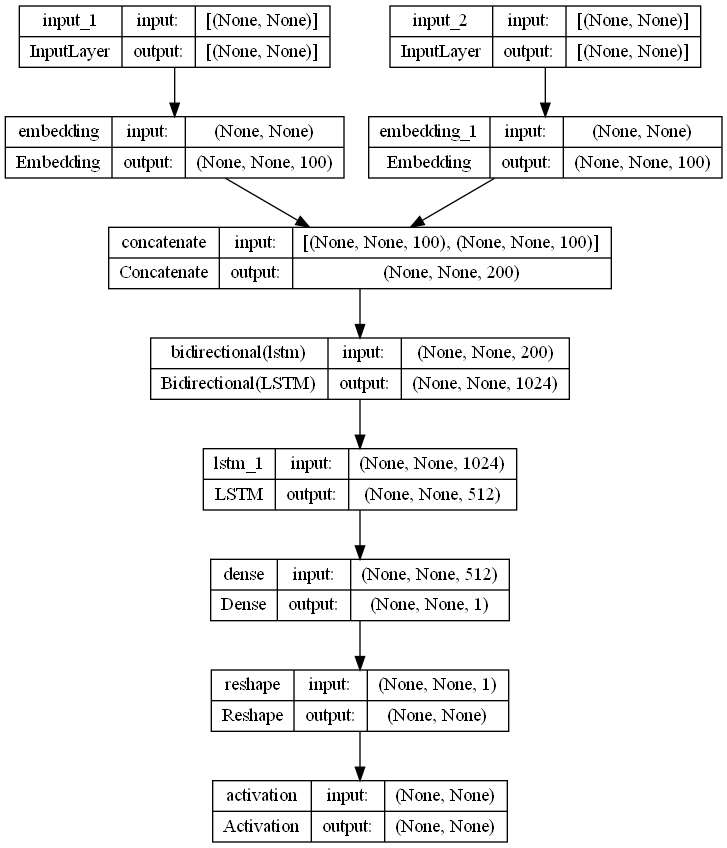

In [35]:
plot_model(att_model, show_shapes = True, show_layer_names = True)

In [36]:
filename = 'lstm_att_mozart'
path = './best_weights_' + filename + '.hdf5'
    
checkpoint = ModelCheckpoint(filepath=path,
                             save_freq=100,
                             monitor='loss', 
                             mode='min', 
                             save_best_only=False, 
                             verbose=0)
    
early_stopping = EarlyStopping(monitor='loss', 
                               mode='min', 
                               restore_best_weights=True,
                               patience=10, 
                               verbose=0)

In [29]:
history = model.fit(network_input,
                    network_output,
                    batch_size=64,   # increased batch_size from 32 to 64
                    epochs=200,
                    callbacks=[checkpoint],
                    shuffle=True,
                    verbose=1)

Epoch 1/200
358/358 [==============================] - 18s 26ms/step - loss: 7.4756 - pitch_loss: 6.7057 - duration_loss: 0.7698
Epoch 2/200
358/358 [==============================] - 9s 26ms/step - loss: 6.6421 - pitch_loss: 6.0466 - duration_loss: 0.5955
Epoch 3/200
358/358 [==============================] - 9s 25ms/step - loss: 6.0959 - pitch_loss: 5.5457 - duration_loss: 0.5502
Epoch 4/200
358/358 [==============================] - 9s 26ms/step - loss: 5.6354 - pitch_loss: 5.1406 - duration_loss: 0.4948
Epoch 5/200
358/358 [==============================] - 9s 25ms/step - loss: 5.2003 - pitch_loss: 4.7644 - duration_loss: 0.4359
Epoch 6/200
358/358 [==============================] - 9s 26ms/step - loss: 4.7891 - pitch_loss: 4.4113 - duration_loss: 0.3778
Epoch 7/200
358/358 [==============================] - 9s 26ms/step - loss: 4.3834 - pitch_loss: 4.0567 - duration_loss: 0.3267
Epoch 8/200
358/358 [==============================] - 9s 25ms/step - loss: 4.0026 - pitch_loss: 3.7211

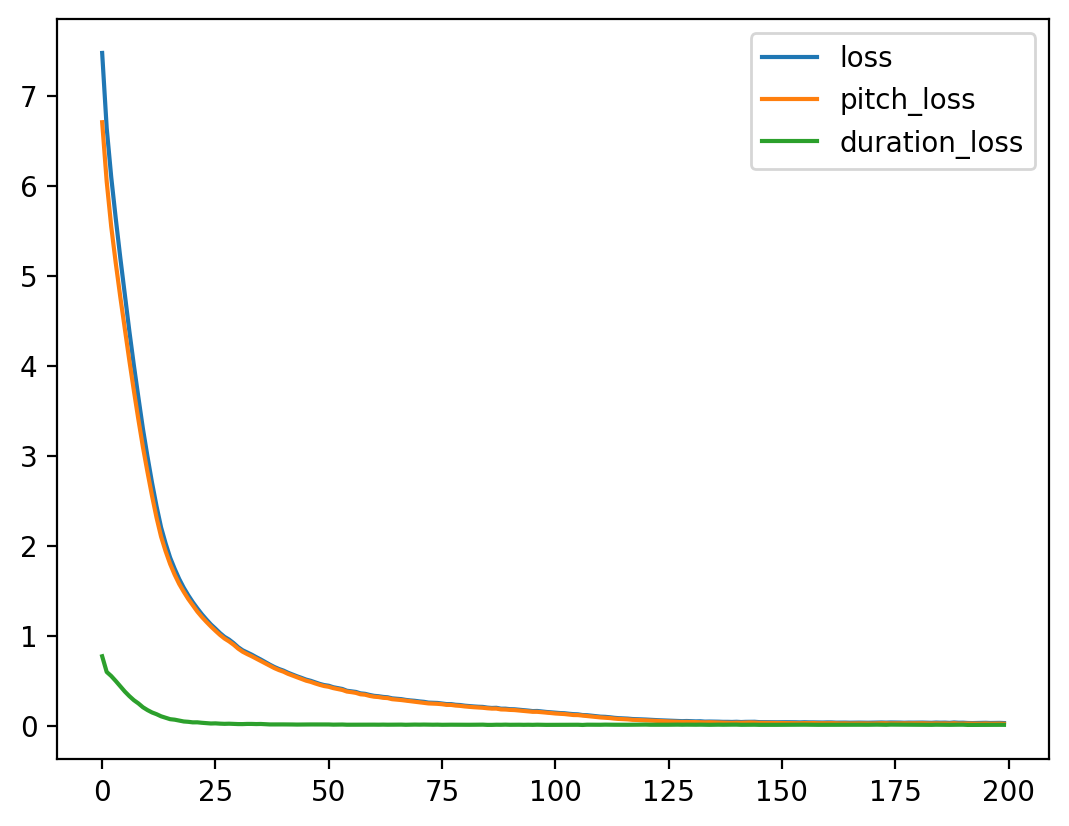

In [30]:
# training history on Mozart (512 units) Bi-LSTM  More notes on Mozart midi files compared to Bach
pd.DataFrame(history.history).plot();

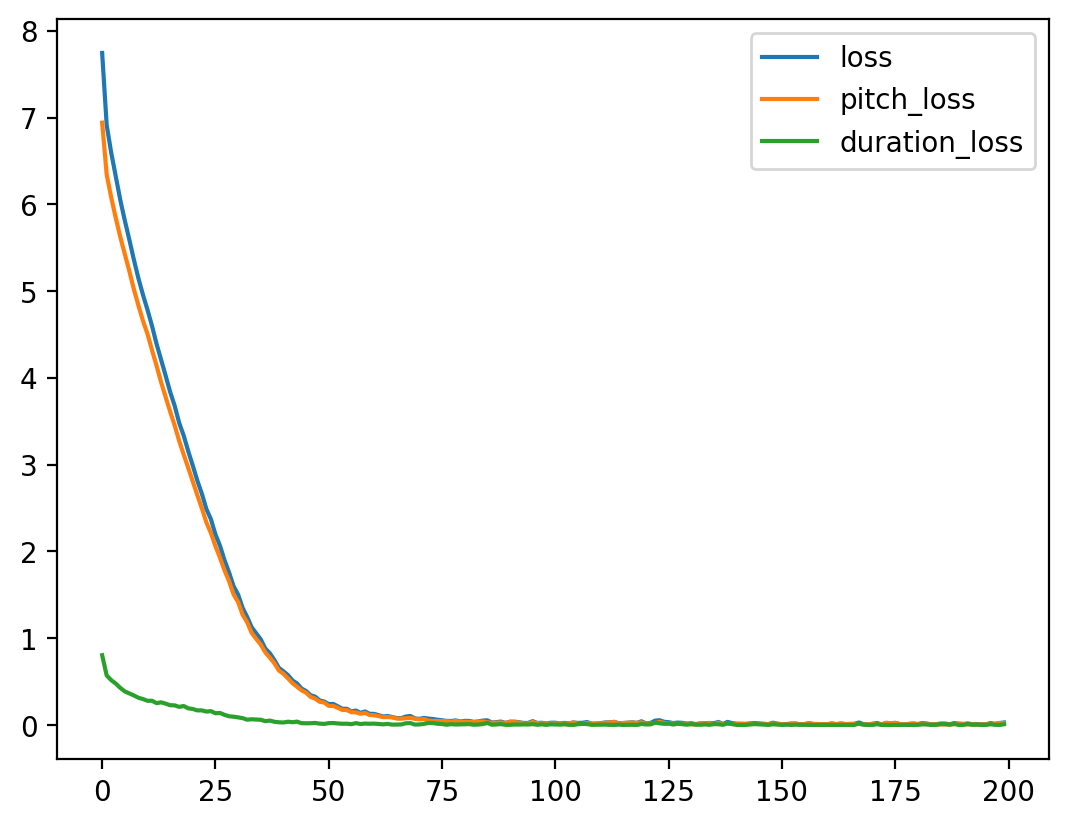

In [41]:
# training history on Bach (512 units) Bi-LSTM
pd.DataFrame(history.history).plot();

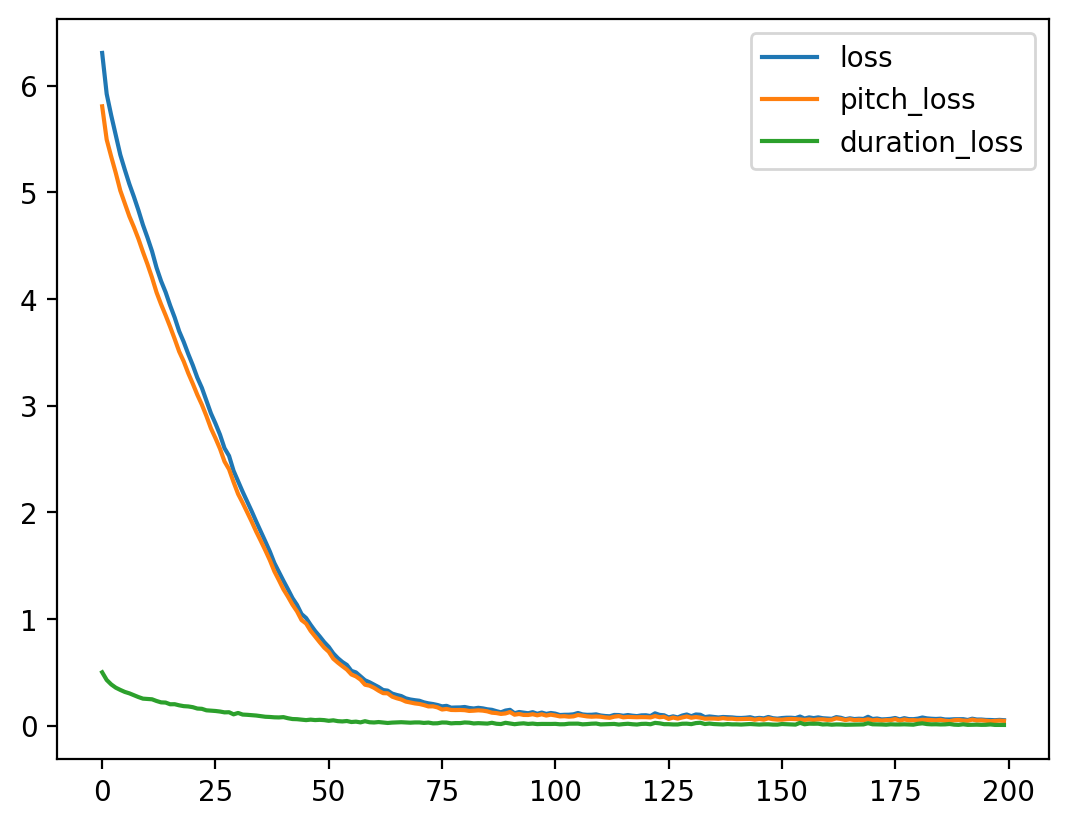

In [70]:
# training history on Bach (256 units) LSTM
#pd.DataFrame(history.history).plot();

In [31]:
model.save('model_trained_on_mozart.keras')

In [61]:
#model = keras.models.load_model('model_trained_on_bach.keras')

In [17]:
# prediction parameters
notes_temp = 0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations

sequence_length = len(notes)

In [18]:
def sample_with_temp(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [19]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []
overall_preds = []

for n, d in zip(notes, durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)
    
    prediction_output.append([n, d])
    
    if n != 'START':
        midi_note = note.Note(n)
        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)

att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)

    att_prediction = att_model.predict(prediction_input, verbose=0)[0]
    att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction
    
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i            
        except:
            pass
        
    overall_preds.append(new_note)            
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)    

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 82 notes


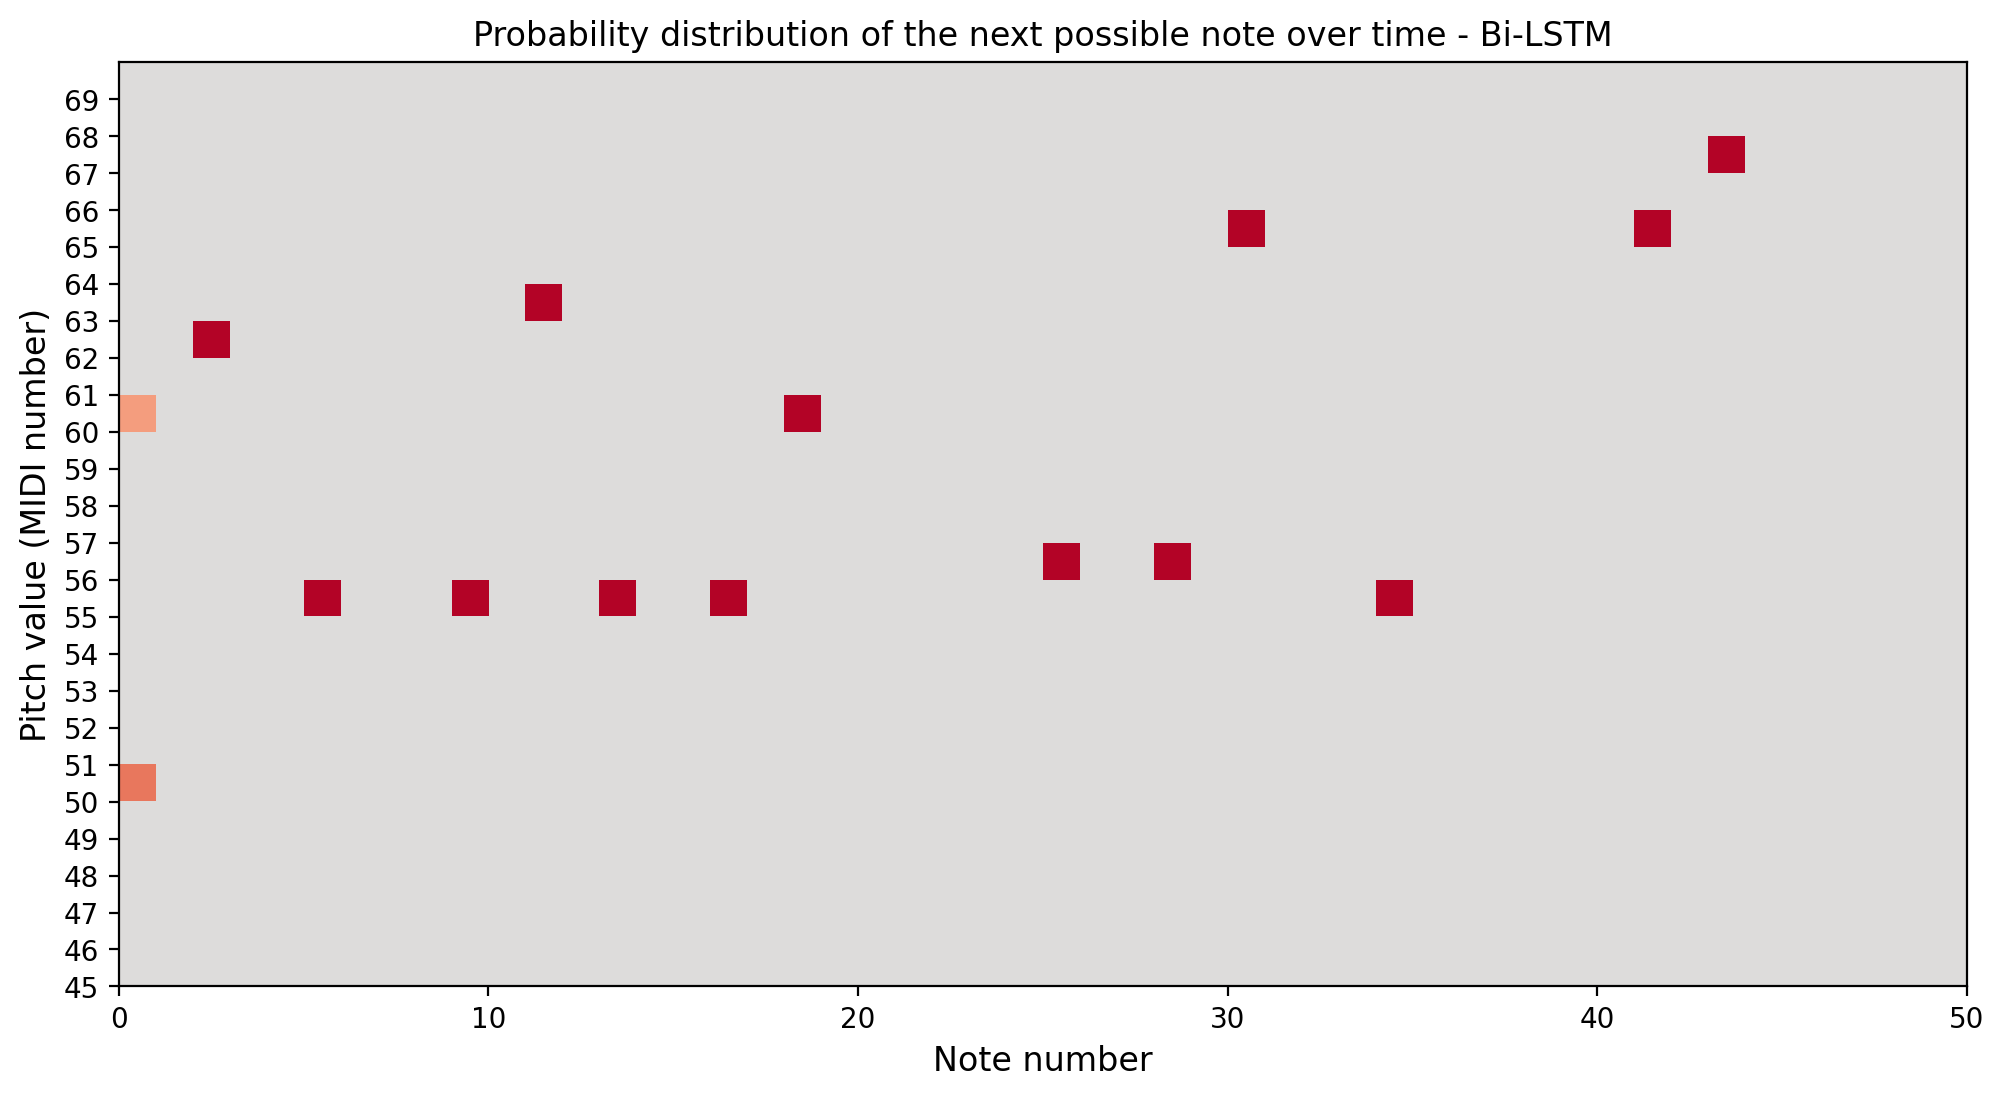

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_yticks([int(j) for j in range(45, 70)])
plt.imshow(overall_preds[45:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 45, 70])
plt.xlabel("Note number", fontsize=12)
plt.ylabel("Pitch value (MIDI number)", fontsize=12)
plt.title("Probability distribution of the next possible note over time - Bi-LSTM", fontsize=12);    # Bi_LSTM - Bach

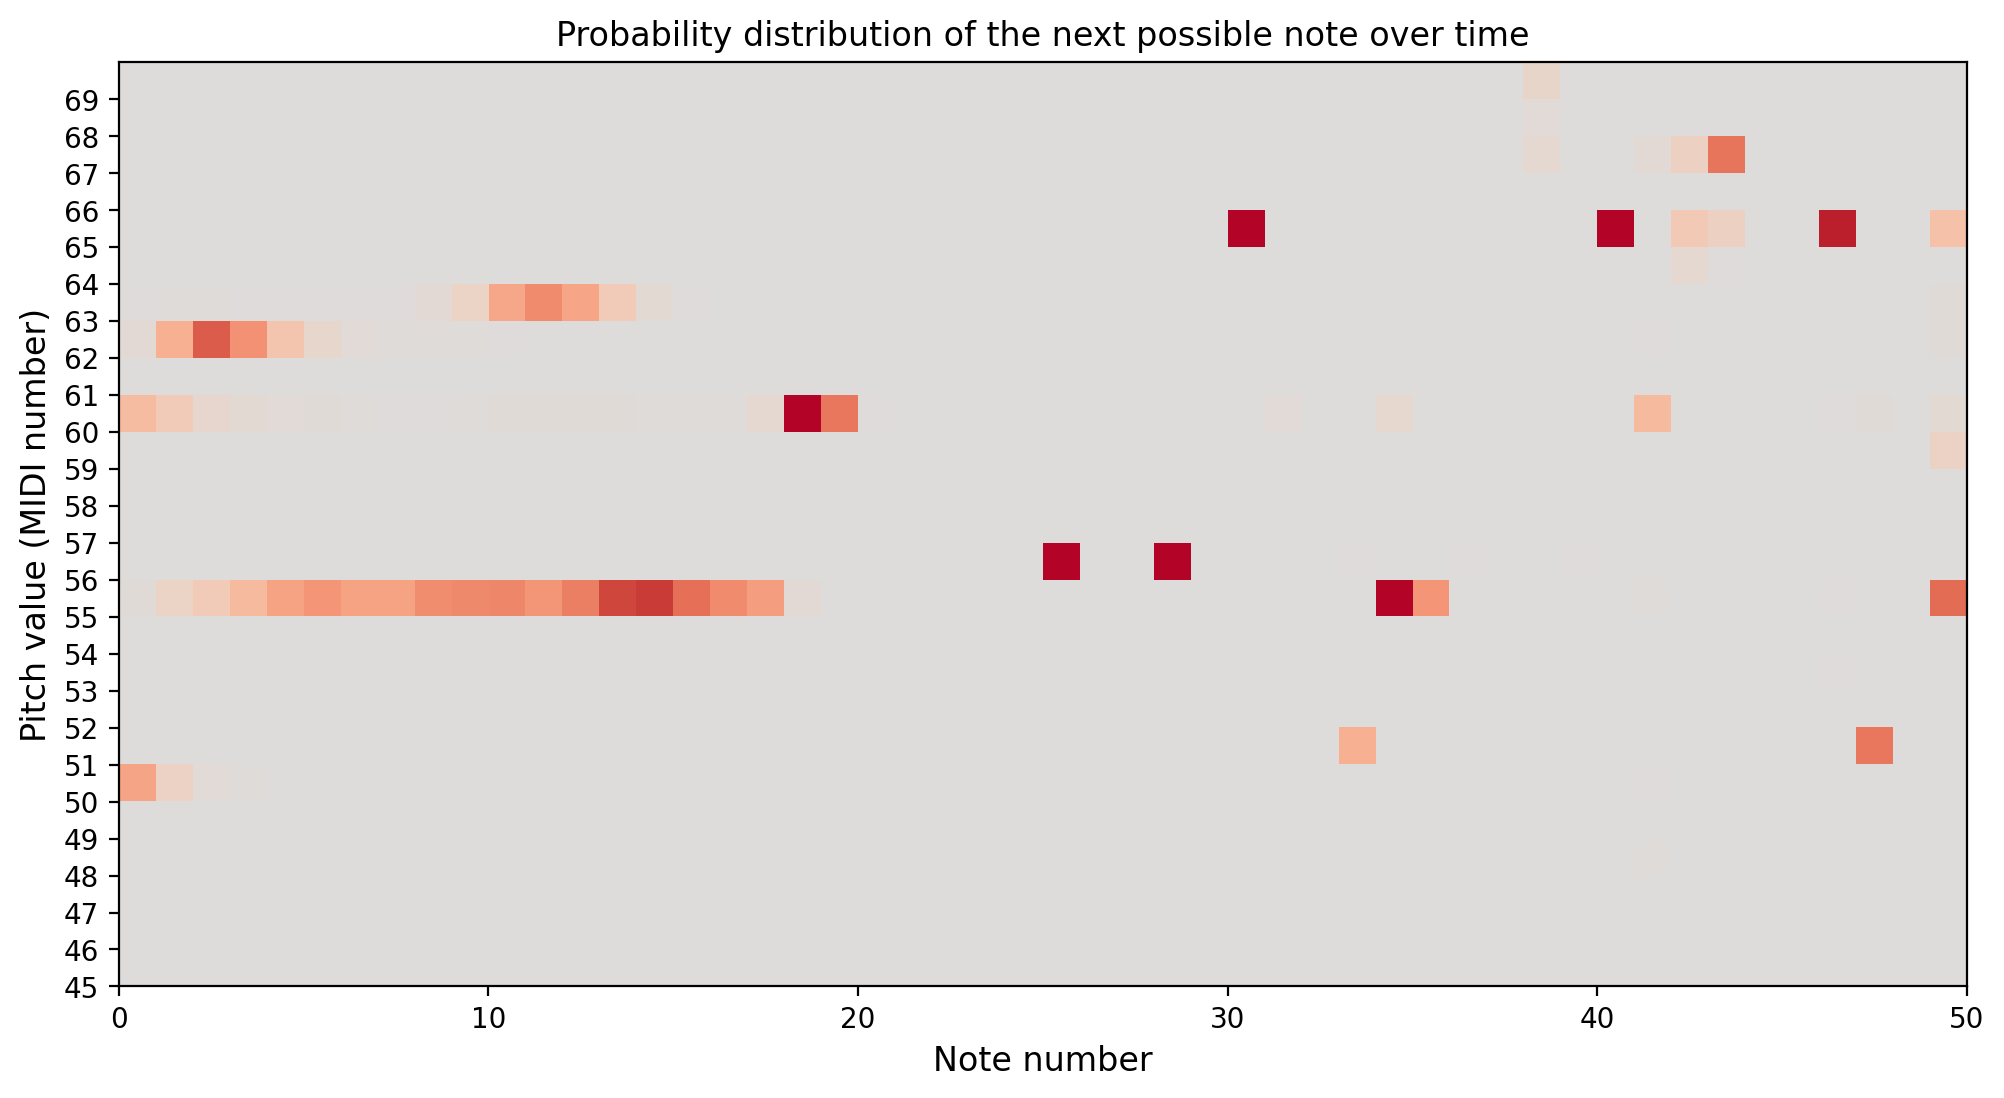

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_yticks([int(j) for j in range(45, 70)])
plt.imshow(overall_preds[45:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 45, 70])
plt.xlabel("Note number", fontsize=12)
plt.ylabel("Pitch value (MIDI number)", fontsize=12)
    Bachplt.title("Probability distribution of the next possible note over time", fontsize=12);    # LSTM - Bach

In [43]:
output_folder = 'output'

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Piano()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Piano()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Piano()
        midi_stream.append(new_note)

midi_stream = midi_stream.chordify()
composer = ''
new_file = 'output-' + composer + '.mid'
midi_stream.write('midi', fp=os.path.join(output_folder, new_file))

'output\\output-mozart2.mid'

#### Mozart-style Generated Score

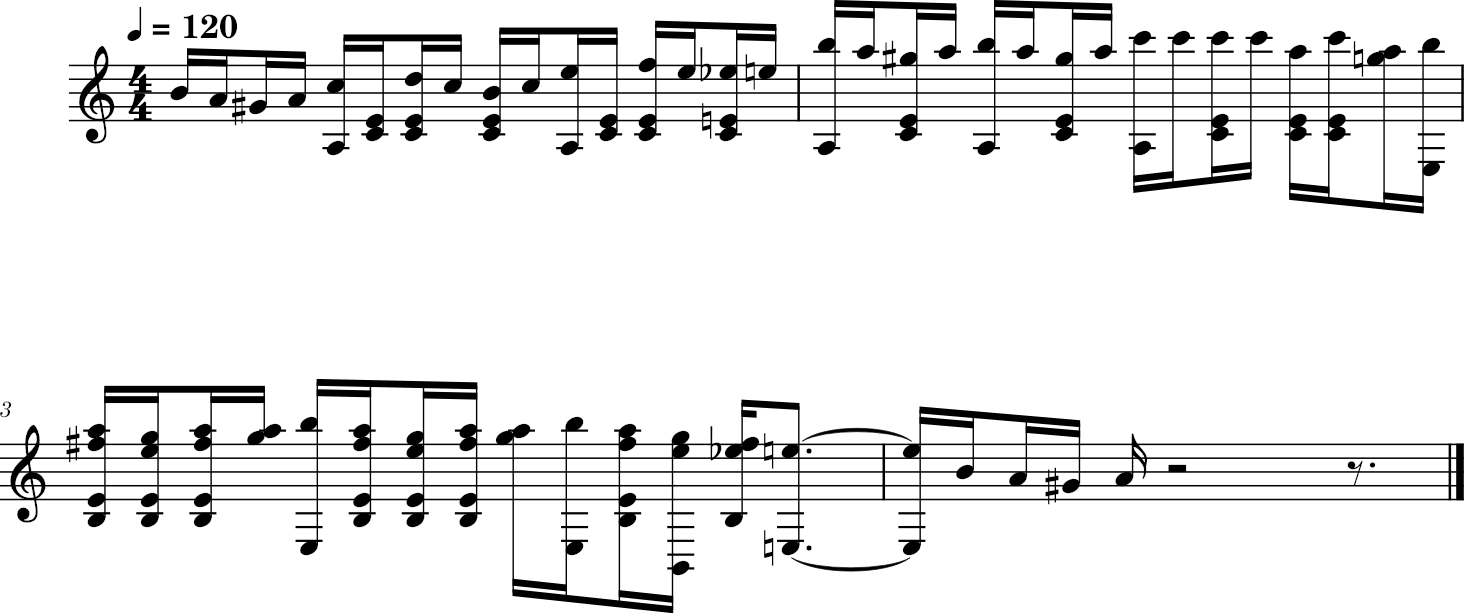

In [37]:
output_path = "output/output-mozart.mid"
output_score = converter.parse(output_path).chordify()
output_score.show()

#### Chopin-style Generated Score

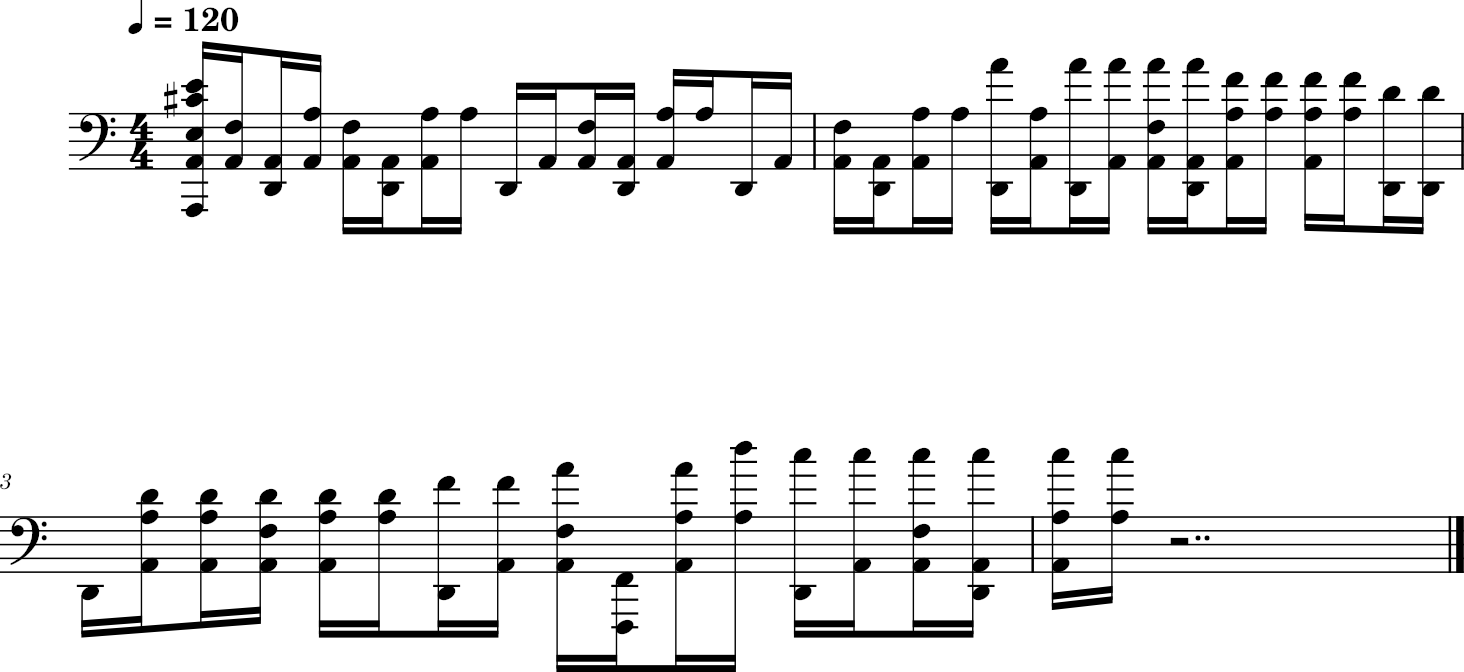

In [37]:
output_path = "output/output-chopin.mid"
output_score = converter.parse(output_path).chordify()
output_score.show()

#### Beethoven-style Generated Score

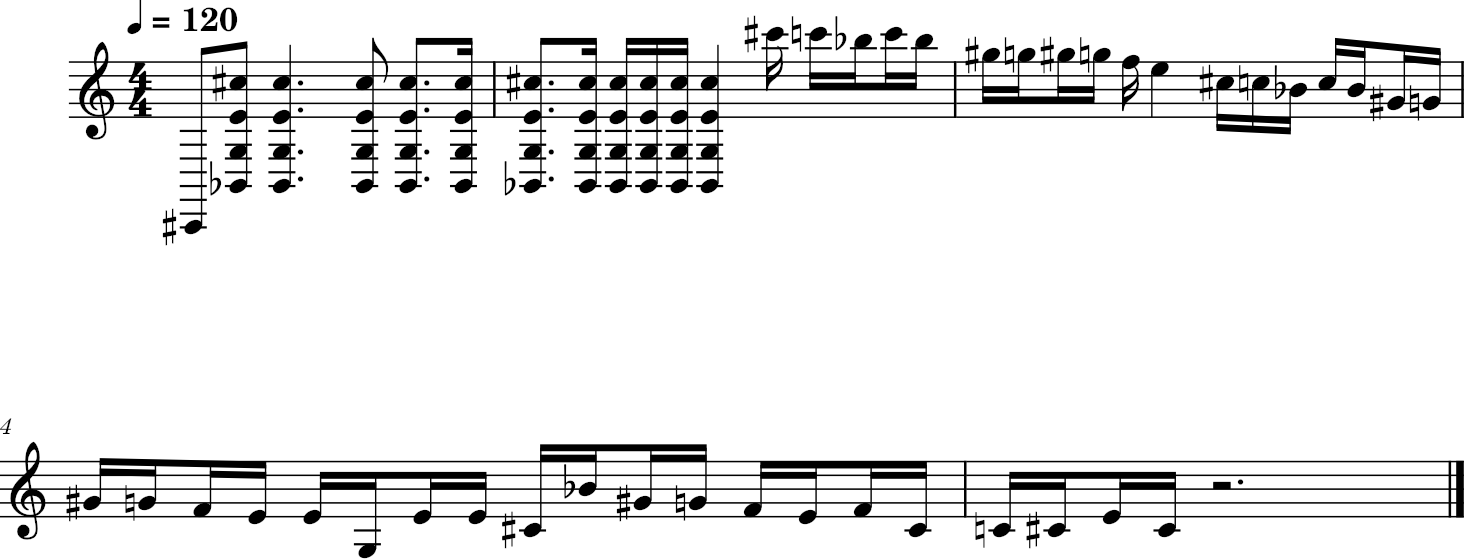

In [84]:
output_path = "output/output-beethoven.mid"
output_score = converter.parse(output_path).chordify()
output_score.show()

#### Bach-style Generated Score

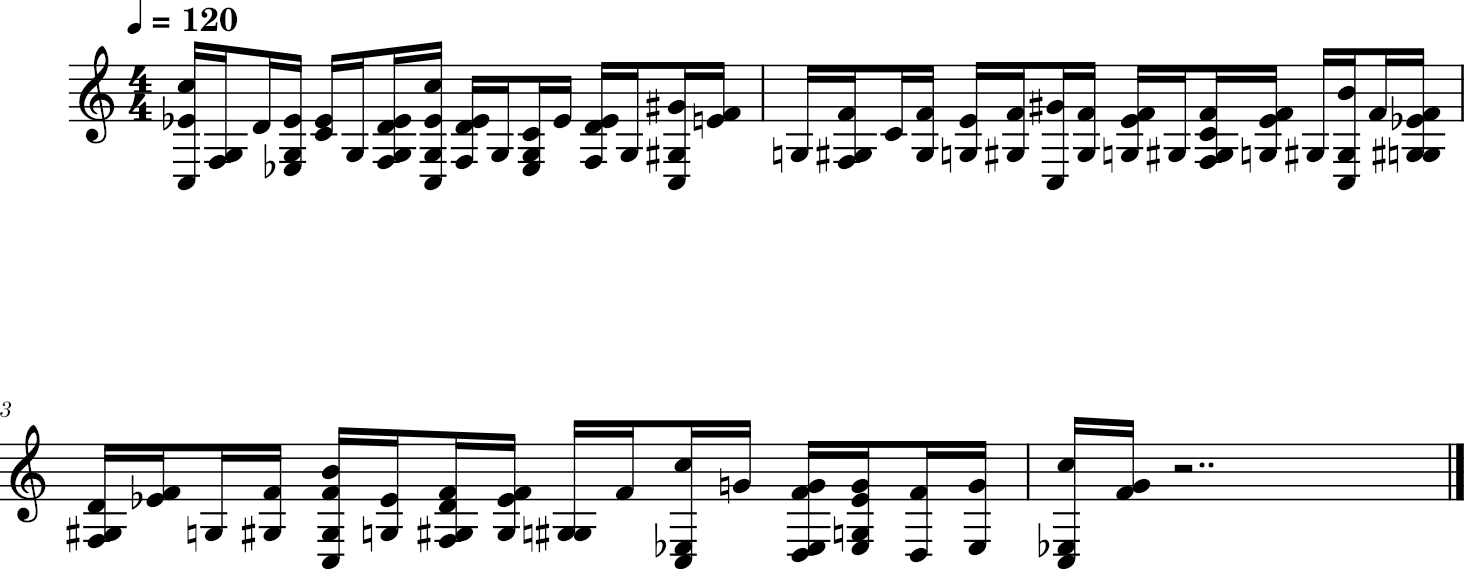

In [48]:
output_path = "output/output-bach.mid"
output_score = converter.parse(output_path).chordify()
output_score.show()

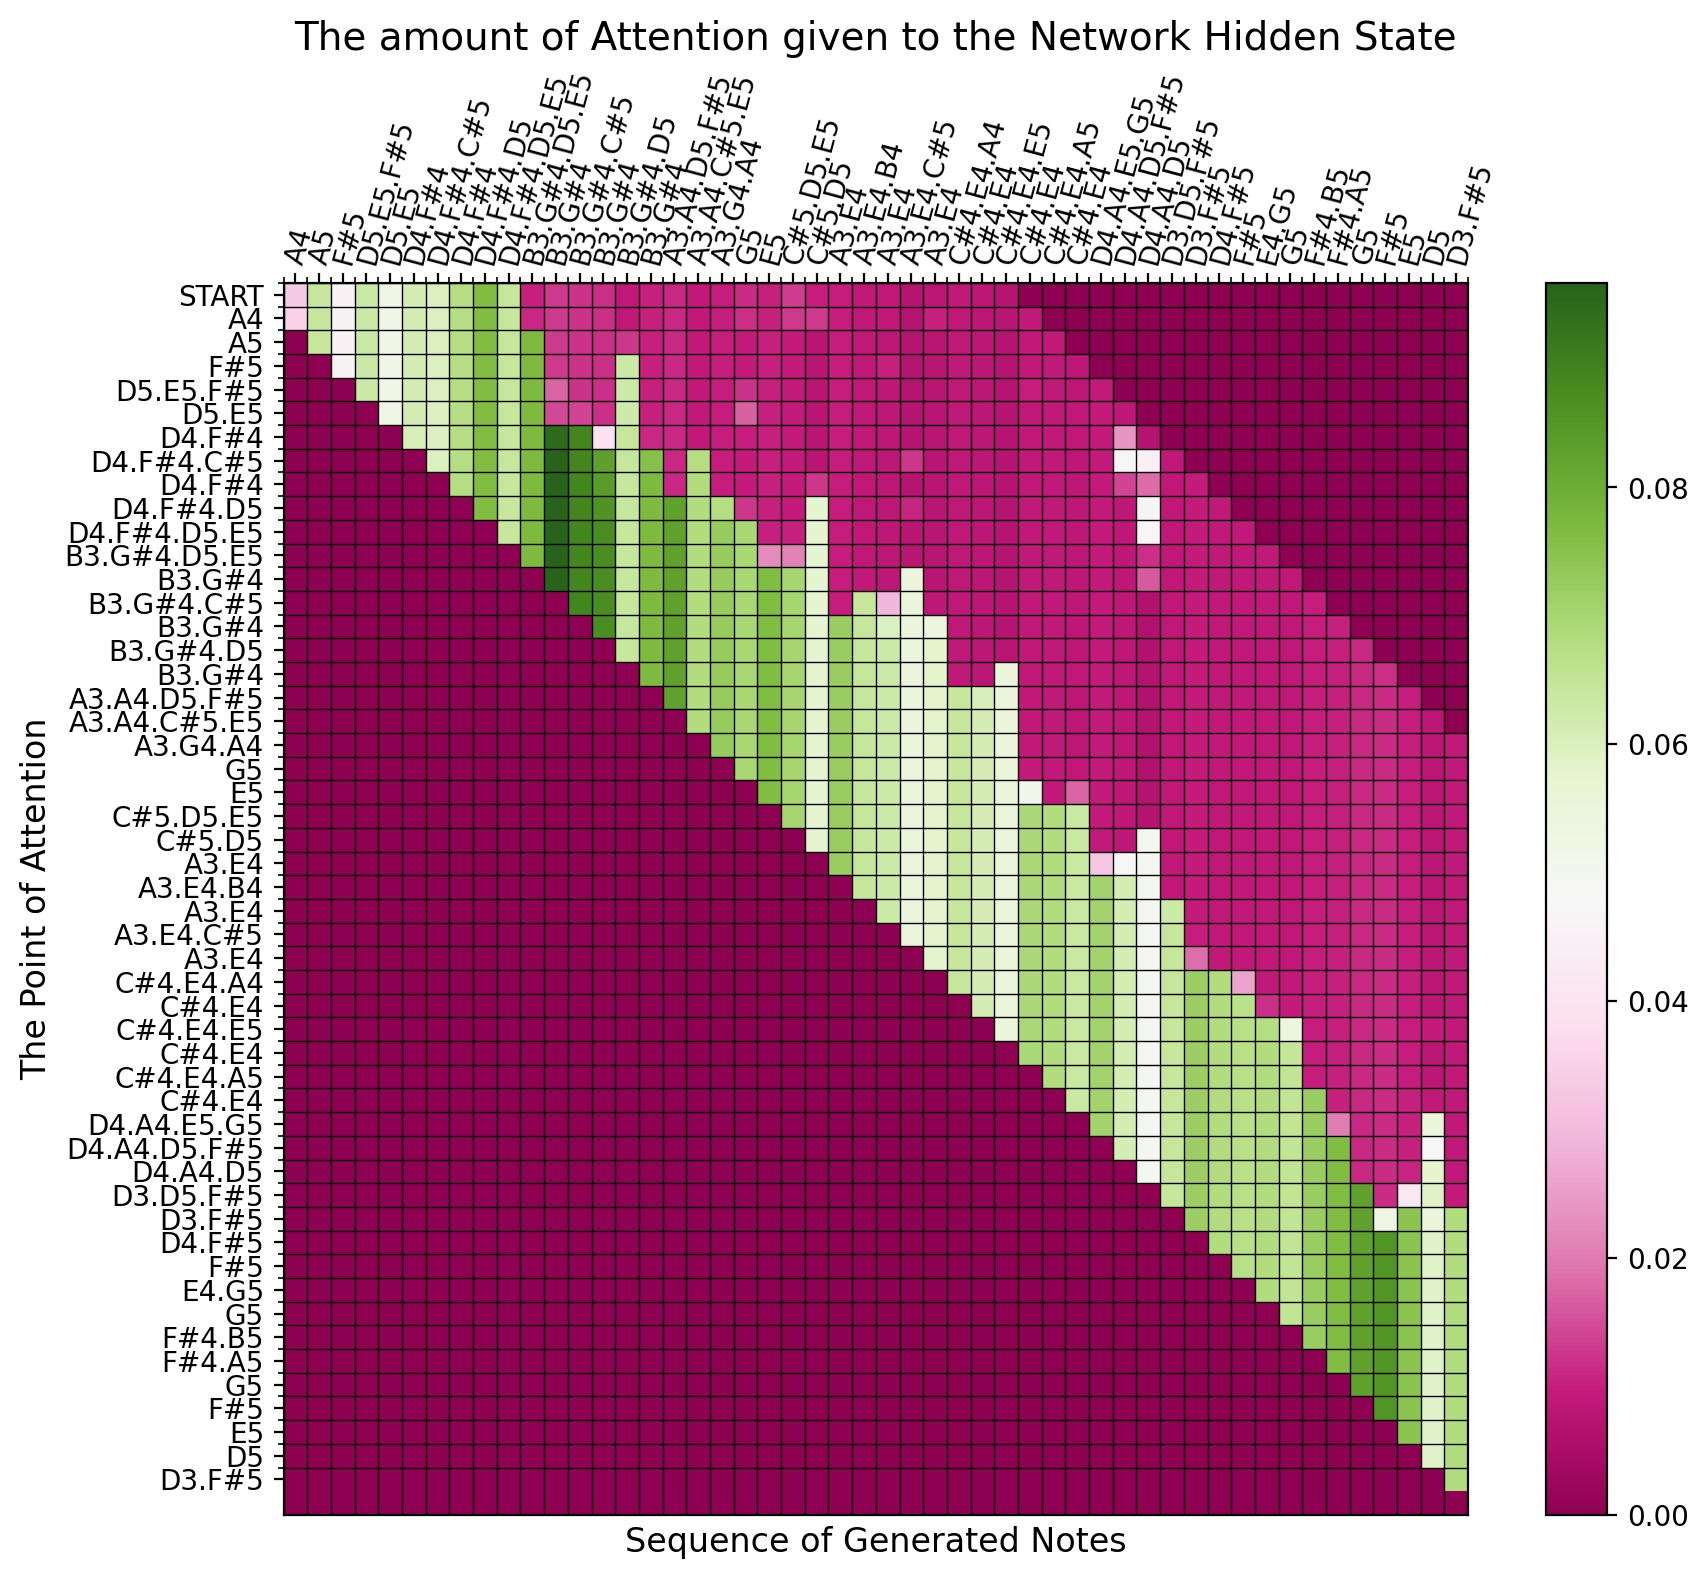

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(att_matrix[(seq_len-2):,], cmap='PiYG', interpolation='nearest')    

# minor ticks
ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

# gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)    
    
# show all ticks
ax.set_xticks(np.arange(len(prediction_output) - seq_len))
ax.set_yticks(np.arange(len(prediction_output)- seq_len + 1))

# label them with the respective list entries
ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 1):]])
ax.xaxis.tick_top()
fig.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=75, ha="left", va = "center", rotation_mode="anchor")
plt.xlabel("Sequence of Generated Notes", fontsize=12)
plt.ylabel("The Point of Attention", fontsize=12)
plt.title("The amount of Attention given to the Network Hidden State", fontsize=14)
plt.show()

### Conclusion
The sound generated is quite distinct for each composer (Bach, Beethoven). This is due to cherry-picked the input (original score). For example for Chopin's composition I filtered out Chopin's Op.18 since it has waltz elements. I think this helped maintain coherence in the generated music.

I generated 2 outpus for each composer. The first generated mozart was very similar to mz_331_3.mid (Rondo Alla Turca), so I generated another one, turned out it was a fluke.

### References
* Andrew Ng. 5th course - Sequence Model - RNN. [*Sequence Models Complete Course*](https://www.youtube.com/watch?v=S7oA5C43Rbc)
* Tensorflow tutorial. [*Generate music with an RNN*](https://www.tensorflow.org/tutorials/audio/music_generation)
* Alex Issa. Article: [*Generating Original Classical Music with an LSTM Neural Network and Attention*](https://medium.com/@alexissa122/generating-original-classical-music-with-an-lstm-neural-network-and-attention-abf03f9ddcb4)
* Alex Issa. [*GitHub Repo: DataScienceMusic*](https://github.com/alexissa32/DataScienceMusic)